In [1]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm #from tqdm.notebook  import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import time as time_module
from mpl_toolkits import mplot3d

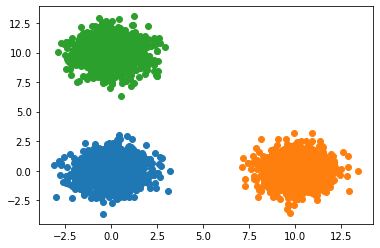

In [2]:
a = np.random.randn(1000, 2)
b = np.array([10, 0]) + np.random.randn(1000, 2)
c = np.array([0, 10]) + np.random.randn(1000, 2)

plt.figure()
plt.scatter(a[:, 0], a[:, 1])
plt.scatter(b[:, 0], b[:, 1])
plt.scatter(c[:, 0], c[:, 1])
plt.show()

# Implementation notes

AAE


---


AAE is straightforward to implement. Only difference here is I experimented with KL divergence losses to separate clusters.


# Objective functions

In [5]:
class GaussianLoss(nn.Module):
    def __init__(self, reduction = "sum"):
        super(GaussianLoss, self).__init__()
        self.reduction = reduction
    
    def forward(self, x_recon, x):

        if isinstance(x_recon, tuple):
            #Learnt a variance on the output
            mu_recon, var_recon = x_recon

        else:
            #No learnt variance on the output
            mu_recon = x_recon
            var_recon = torch.ones_like(x_recon).requires_grad_(False)
        
        error = x - mu_recon

        B, N = x.size()
        #Assuming diagonalised covariance:
        gauss_log_loss = torch.mul(error.pow(2), 1/(2 * var_recon + 1e-12)) #2x100 error vector is needed to do normal multiplication
        gauss_log_loss += 1/2 * torch.log(var_recon + 1e-12)

        #Sum over dimensionality
        gauss_log_loss = torch.sum(gauss_log_loss, dim = 1, keepdim = True)
        
        if self.reduction.lower() == "sum":
            gauss_log_loss =  torch.sum(gauss_log_loss)

        return gauss_log_loss #Unnormalised



class KL_divergence(nn.Module):

    """
    Implement the KL divergence loss for Gaussian distributions
    """

    def __init__(self, std_normal = False):
        super(KL_divergence, self).__init__()

        self.std_normal = std_normal #A flag to check whether the loss

    def forward(self, mu_0, var_0, mu_1 = None, var_1 = None):

        if self.std_normal:
            mu_1 = torch.zeros_like(mu_0).requires_grad_(False)
            var_1 = torch.ones_like(var_0).requires_grad_(False)

        #perform everything elementwise and then 
        Dkl = var_0 / var_1 + ((mu_1 - mu_0)**2) / var_1 - 1 + torch.log(var_1 / var_0  + 1e-12)

        #Sum over dimensionality
        Dkl = 0.5 * torch.sum(Dkl, dim = 1, keepdim = True)

        return Dkl #Unnormalised

class discrete_KL_divergence(nn.Module):
    """
    Implement the KL divergence loss for sampled distributions with likelihoods
    """
    def __init__(self, no_classes):
        super(discrete_KL_divergence, self).__init__()

        self.no_classes = no_classes

    def batch_wise_entropy(self, batch_likelihoods): #Maximise this term
        B = batch_likelihoods.size(0)

        p_hat = 1/B * torch.sum(batch_likelihoods, dim = 0).reshape(1, -1)

        #print(np.round(p_hat.detach().cpu().numpy(), 3))

        batch_entropy = -B * torch.sum(p_hat * torch.log(p_hat + 1e-12))
        #print(batch_entropy / B)
        return batch_entropy

    def forward(self, class_prob, prior_prob = None):

        assert class_prob.size(1) == self.no_classes, "There is a mis-match between the pre-defined number of classes and the number of classes given to the discrete KL divergence."

        if prior_prob is None:
              prior_prob = torch.ones(self.no_classes) / self.no_classes

        #perform everything elementwise and then you can reduce if required
        entropy = -1 * torch.sum(class_prob * torch.log(class_prob + 1e-12), dim = 1, keepdim = True) #Entropy term
        cross_entropy = -1 * torch.sum(class_prob * torch.log(prior_prob + 1e-12), dim = 1, keepdim = True)  #Cross-entropy term
        batch_entropy = self.batch_wise_entropy(class_prob) #Batch entropy term (maximise hence minus sign)
        Dkl = entropy - cross_entropy - batch_entropy

        return Dkl, torch.mean(entropy), torch.mean(cross_entropy) #Unnormalised and I sign-corrected the entropy term.

class MoG_VAE_loss(nn.Module):
    #No ability to learn a variance, variance is controlled by the noise distribution for iVAE
    def __init__(self, no_classes, loss_name = "L2", gamma = 1, beta = 1, alpha = 1, CURL_flag = False, Gumbel_flag = False):
        super(MoG_VAE_loss, self).__init__()

        self.no_classes = no_classes

        self.gamma = gamma #Reconstruction loss KL parameter
        self.beta = beta #Continuous KL parameter
        self.alpha = alpha #Categorial KL parameter

        self.loss_name = loss_name

        self.CURL_flag = CURL_flag
        self.Gumbel_flag = Gumbel_flag

        if self.loss_name.lower() == "l2":
            self.recon_loss = GaussianLoss(reduction = 'none')
        
        elif self.loss_name.lower() == "l1":
            self.recon_loss = nn.L1Loss(reduction = 'none')
        
        elif self.loss_name.lower() == "bce":
              self.recon_loss = nn.BCELoss(reduction = 'none')
        
        else:
            print("Unknown loss entered.")
            raise SystemExit
        
        self.kl_loss = KL_divergence(False) #Never use a standard VAE case
        self.discrete_kl_loss = discrete_KL_divergence(self.no_classes)
        
        #######################
        #Semi-supervised losses
        #######################
        if self.CURL_flag:
            self.ss_loss_classes = torch.nn.CrossEntropyLoss()
            self.ss_loss_posterior = torch.nn.NLLLoss()

        else:
            self.ss_loss_classes = torch.nn.NLLLoss()
            
        self.ss_loss_latent = nn.MSELoss()

    def forward(self, x, recon_x, mu_0, var_0, mu_1, var_1, q_y_G_x, prior_prob = None):
        
        #You need to expand the input data by no_classes and then reshape it!
        #x = torch.repeat_interleave(x, self.no_classes, dim = 0)

        B, N = x.size()

        if isinstance(recon_x, tuple) and self.loss_name.lower() != "l2": #Check if it is a tuple, will be this by default when it is fed in.
            recon_x = recon_x[0]

        #Reconstruction loss
        if self.CURL_flag: #second part of IF helps is you use Gumbel
            #Apply softmax to the output
            q_y_G_x = F.softmax(q_y_G_x, dim = 1)

            x = torch.repeat_interleave(x, self.no_classes, dim = 0)

            Lrecon = torch.sum(self.recon_loss(recon_x, x), dim = 1, keepdim = True)
            Lrecon = Lrecon.reshape(B, self.no_classes)
            Lrecon *= q_y_G_x #weight by categorical likelihood
            Lrecon = torch.sum(Lrecon) / self.no_classes  #Sum all values and normalise by no. of classes

        else:
            Lrecon = torch.sum(self.recon_loss(recon_x, x), dim = 1, keepdim = True)
            Lrecon = torch.sum(Lrecon)  #Sum all values

        if mu_0.size(0) * self.no_classes == mu_1.size(0): #A check to see if you are using single samples for many classes (VaDE only)
            mu_0 = torch.repeat_interleave(mu_0, self.no_classes, dim = 0) #Need to expand data for all the classes
            var_0 = torch.repeat_interleave(var_0, self.no_classes, dim = 0) #Need to expand data for all the classes

        #continuous KL divergence loss
        Lkl_continuous = self.kl_loss(mu_0, var_0, mu_1, var_1) #Need to normalise with same values reconstruction loss (Pytorch does this automatically unless you specify)
        
        if not self.Gumbel_flag:
            Lkl_continuous = Lkl_continuous.reshape(B, self.no_classes)
            Lkl_continuous *= q_y_G_x #weight by categorical likelihood
            
        Lkl_continuous = torch.sum(Lkl_continuous) / self.no_classes #Sum all values and normalise by class size

        #discrete KL divergence loss
        Lkl_discrete, entropy, cross_entropy = self.discrete_kl_loss(q_y_G_x, prior_prob)
        Lkl_discrete = torch.sum(Lkl_discrete)  #Sum all values

        Ltotal = self.gamma * Lrecon + self.beta * Lkl_continuous + self.alpha * Lkl_discrete

        #Normalise value
        Lrecon /= (B * N)
        Lkl_continuous /= (B * N)
        Lkl_discrete /= (B * N)
        Ltotal /= (B * N)

        return Ltotal, Lrecon, Lkl_continuous, Lkl_discrete, entropy, cross_entropy

"""
#TESTING THE FUNCTIONS
no_samples = 512
no_classes = 3
a = torch.randn(no_samples, 5)
b = a + torch.randn_like(a) * 0.1
mu_0 = torch.ones_like(a)
mu_1 = torch.zeros_like(a)
var_0 = torch.ones_like(a)
var_1 = torch.ones_like(a)

a = torch.repeat_interleave(a, no_classes, dim = 0)
b = torch.repeat_interleave(b, no_classes, dim = 0)
mu_0 = torch.repeat_interleave(mu_0, no_classes, dim = 0)
mu_1 = torch.repeat_interleave(mu_1, no_classes, dim = 0)
var_0 = torch.repeat_interleave(var_0, no_classes, dim = 0)
var_1 = torch.repeat_interleave(var_1, no_classes, dim = 0)

loss = MoG_VAE_loss(no_classes)
q_y_G_x = torch.ones(no_samples, no_classes) / no_classes

print(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, False))
print(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, True))
print(torch.mean((b - a)**2)/2, torch.mean((b - a)**2)/(2 * no_classes))
"""

'\n#TESTING THE FUNCTIONS\nno_samples = 512\nno_classes = 3\na = torch.randn(no_samples, 5)\nb = a + torch.randn_like(a) * 0.1\nmu_0 = torch.ones_like(a)\nmu_1 = torch.zeros_like(a)\nvar_0 = torch.ones_like(a)\nvar_1 = torch.ones_like(a)\n\na = torch.repeat_interleave(a, no_classes, dim = 0)\nb = torch.repeat_interleave(b, no_classes, dim = 0)\nmu_0 = torch.repeat_interleave(mu_0, no_classes, dim = 0)\nmu_1 = torch.repeat_interleave(mu_1, no_classes, dim = 0)\nvar_0 = torch.repeat_interleave(var_0, no_classes, dim = 0)\nvar_1 = torch.repeat_interleave(var_1, no_classes, dim = 0)\n\nloss = MoG_VAE_loss(no_classes)\nq_y_G_x = torch.ones(no_samples, no_classes) / no_classes\n\nprint(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, False))\nprint(loss(a, b, mu_0, var_0, mu_1, var_1, q_y_G_x, True))\nprint(torch.mean((b - a)**2)/2, torch.mean((b - a)**2)/(2 * no_classes))\n'

# GAN losses

In [21]:
class InfoGAN_loss(nn.Module):
    def __init__(self):
        super(InfoGAN_loss, self).__init__()
        #Gaussian loss and Cross entropy loss
        self.MSEloss = nn.MSELoss()
        self.CEloss = nn.NLLLoss()
    
    def forward(self, s_orig, s_recon, c_recon = None, c_targets = None):
        
        loss_s = self.MSEloss(s_orig, s_recon)
        
        if c_recon is not None:
            loss_c = self.CEloss(c_recon, c_targets)
        
            return loss_s, loss_c
        
        else:
            return loss_s

class GradientPenalty(nn.Module):
    def __init__(self):
        super(GradientPenalty, self).__init__()

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    def forward(self, x_real, x_gen, discriminator):
        B = x_real.size(0)
        
        #set up data for interpolation
        SizeList = [B] + [1] * len(x_real.size()[1:]) #BatchSize x 1 or BatchSize x 1 x 1 x 1
        epsilon = torch.rand(SizeList).to(self.device) #Set it to a Nx1 vector that you can then expand if need be
        epsilon = epsilon.expand_as(x_real) #Replicate for each data point
        
        #generate interpolated data and make it differentiable
        with torch.no_grad():
            interpolation = epsilon * x_real + (1 - epsilon) * x_gen
            
        interpolation = interpolation.requires_grad_(True).to(self.device)
        
        #Push through discriminator
        Dinter = discriminator(interpolation)
        
        #Generate dDdX gradient vector - Make it one as we want dDdX = [[dD1/dX1 + dD2/dX1],[]] (A n by 1 vector)
        GradOut = torch.ones_like(Dinter).requires_grad_(False)
        
        GradX = torch.autograd.grad(outputs = Dinter, inputs = interpolation, grad_outputs = GradOut,  create_graph = True, retain_graph = True)[0]
        NormX = torch.sqrt(torch.sum(GradX.view(B, -1).pow(2), dim = 1) + 1e-12)
        
        GP = (NormX - 1).pow(2).mean()

        return GP

class ConsensusOptimisation(nn.Module):
    def __init__(self):
        super(ConsensusOptimisation, self).__init__()
        #TODO implement CO loss calculator
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  
    def foward(self, lossD, lossG, discriminator, generator):
        #################
        #Consensus Losses
        #################

        #Get gradients (not using .backward)
        GradD = torch.autograd.grad(lossD, discriminator.parameters(), create_graph = True)
        GradG = torch.autograd.grad(lossG, generator.parameters(), create_graph = True)
        #GradDz = torch.autograd.grad(torch.mean(outputs[2]), outputs[3], create_graph = True, retain_graph = True)     
        
        normD = sum([torch.norm(gradient).pow(2) for gradient in GradD])
        normG = sum([torch.norm(gradient).pow(2) for gradient in GradG])
        #normZ = sum([torch.norm(gradient) for gradient in GradDz])
        #lossNorm =  self.gamma * (1/2) * (normD + normG)
        #lossNormZ = self._lambda * normZ
    
        #CalculateNormPercentages
        #percent_normD = np.round(normD.item(), 3)
        #percent_normG = np.round(normG.item(), 3) 

        return normD + normG

class GANloss(nn.Module):
    def __init__(self, GANType, GenType, InfoGAN = False, CO_flag = False):
        super(GANloss, self).__init__()
        self.gan_type = GANType
        self.gen_type = GenType
        self.InfoGAN = InfoGAN
        self.CO_flag = CO_flag
        
        if self.gan_type.lower() == "wasserstein":
            print("Using Wasserstein GAN loss")
            self.CostD = self.GANLoss_D(Wasserstein = True)
            self.CostG = self.GANLoss_G(Wasserstein = True, GenType = self.gen_type)
            self.GP = GradientPenalty()

        elif self.gan_type.lower() == "hinge":
            print("Using hinge GAN loss")
            self.CostD = self.GANLoss_D(Hinge = True)
            self.CostG = self.GANLoss_G(Hinge = True, GenType = self.gen_type)
        
        else:
            print("Using standard GAN loss")
            self.CostD = self.GANLoss_D()
            self.CostG = self.GANLoss_G(GenType = self.gen_type)
        
        if self.InfoGAN:
            self.CostInfo = InfoGAN_loss()
        
        if self.CO_flag:
            self.COloss = ConsensusOptimisation()
            
    @staticmethod  
    def GANLoss_D(Wasserstein = False, Hinge = False):
        
        if Wasserstein and not Hinge:
            print("\nUsing Wasserstein GAN loss on D")
            
            def DiscriminatorLoss(Data, Type):
                if Type.lower() == "real":
                    BCE = Data

                        
                elif Type.lower() == "fake":
                    BCE = -1 * Data

                return -1 * torch.mean(BCE)
        
        elif Hinge and not Wasserstein:
            print("\nUsing Hinge GAN loss on D")
            
            def DiscriminatorLoss(Data, Type):
                if Type.lower() == "real":
                    BCE = -1 + Data
                    with torch.no_grad():
                        scale = 1 * (BCE < 0)
                    
                    BCE = BCE * scale

                        
                elif Type.lower() == "fake":
                    BCE = -1 - Data
                    with torch.no_grad():
                        scale = 1 * (BCE < 0)
                    
                    BCE = BCE * scale

                return -1 * torch.mean(BCE)
        
        else:
            print("\nUsing Standard GAN loss on D")
            
            def DiscriminatorLoss(Data, Type):
                if Type.lower() == "real":
                    BCE = torch.log(Data + 1e-16)
                        
                elif Type.lower() == "fake":
                    BCE = torch.log(1 - Data + 1e-16)
        
                return -1 * torch.mean(BCE)
            
        
        return DiscriminatorLoss
    
    @staticmethod  
    def GANLoss_G(Wasserstein = False, Hinge = False, GenType = 1):
        
        if not Wasserstein and not Hinge:
            
            if GenType == 1:
                print("\nUsing Standard GAN loss on G")
                
                def GeneratorLoss(Data):
                    
                    BCE = torch.log(1 - Data + 1e-16)
                    return torch.mean(BCE)

            
            if GenType == 2:
                print("\nUsing non-saturating GAN loss on G")
                
                def GeneratorLoss(Data):

                    BCE = torch.log(Data + 1e-16)
                    return -1 * torch.mean(BCE)

                
            if GenType == 3:
                print("\nUsing KL divergence GAN loss on G")
                def GeneratorLoss(Data):
                    KL = torch.log(Data + 1e-16) - torch.log(1 - Data + 1e-16)
                    return -1 * torch.mean(KL)
        
        elif Hinge and not Wasserstein:
            
            print("\nUsing Hinge GAN loss on G")
            def GeneratorLoss(Data):
                return -1 * torch.mean(Data)
        
        else:
            print("\nUsing Wasserstein GAN loss on G")
            def GeneratorLoss(Data):
                Wass = Data
                return -1 * torch.mean(Wass)
        
        return GeneratorLoss
  
    def forward(self, x_real, x_gen, generator, discriminator, dis_update = True):
        
        #Generator input is only useful if you use Consensus Optimisation
        if self.CO_flag:

            loss_real = self.CostD(discriminator(x_real), "real")
            loss_fake = self.CostD(discriminator(x_gen.detach()), "fake")

            lossD = loss_real + loss_fake
            lossG = self.cost.CostG(discriminator(x_gen))

            #CO is defined for both losses
            loss_total = self.COloss(lossD, lossG, generator, discriminator)

        elif dis_update:
            
            loss_real = self.CostD(discriminator(x_real), "real")
            loss_fake = self.CostD(discriminator(x_gen.detach()), "fake")

            loss_total = loss_real + loss_fake

            if self.gan_type.lower() == "wasserstein": #Add gradient penalty to discriminator loss
                loss_GP = self.GP(x_real, x_gen, discriminator)

                loss_total += loss_GP
        
        else:
            loss_real = 0 #real loss does not contribute to generator update
            loss_fake = self.CostG(discriminator(x_gen))

            loss_total = loss_real + loss_fake

        return loss_total


# Models

In [22]:
# -*- coding: utf-8 -*-
"""
Created on Wed Jun  9 14:19:53 2021

@author: ryanb
"""

import torch
import torch.nn as nn

#Implement similarly to the manner I had previously
#Dict to define layers
#Checks for FF and Convolution
#Add in ability to have variance generating component in decoder (unused at this point)

class Unflatten(nn.Module):
    def __init__(self, ModelDict):
        super(Unflatten, self).__init__()
        self.ModelDict = ModelDict
        
    def forward(self, input_tensor):
        
        First_no_channels = self.ModelDict["channels"][0]

        input_tensor = input_tensor.view(-1, First_no_channels, int(input_tensor.size(1) / First_no_channels))
        
        return input_tensor

class Flatten(nn.Module): #Same name as tensorflow tf.keras.Flatten()
    def __init__(self, DisDict):
        super(Flatten, self).__init__()
        self.DisDict = DisDict
        
    def forward(self, input_tensor):

        input_tensor = input_tensor.view(input_tensor.size(0), -1)
        
        return input_tensor

class CondEncoder(nn.Module): #conditional VAE
    def __init__(self, encode_dict, activation):
        super(CondEncoder, self).__init__()
        
        self.encode_dict = encode_dict
        self.activation = activation
        self.layers = []
        
        if self.encode_dict["conv_flag"]:
            
            self.conv_layers = []
            for i in range(len(self.encode_dict["channels"]) - 1):

                #append the layer
                self.conv_layers.append( nn.Conv1d(in_channels = self.encode_dict["channels"][i], out_channels = self.encode_dict["channels"][i + 1], kernel_size = self.encode_dict["kernel_size"][i], stride = self.encode_dict["stride"][i], padding = self.encode_dict["padding"][i]) )
                #append the activation function
                self.conv_layers.append(self.activation)
            
            #append the transform to take the nn.linear to a convolutional layer
            self.conv_layers.append(Flatten(self.encode_dict))
            
            self.conv_encode = nn.Sequential(*self.conv_layers)
                
            
        for i in range(len(self.encode_dict["ff_layers"]) - 2):
            #append the layer
            self.layers.append(nn.Linear(in_features = self.encode_dict["ff_layers"][i], out_features = self.encode_dict["ff_layers"][i + 1], bias = True))
            #append the activation function
            self.layers.append(self.activation)
        
        self.layers.pop(-1)
        self.ff_encode = nn.Sequential(*self.layers)
        
    def forward(self, x, labels = None, cont_input = None):
        #Takes in both the x and u variables
        #Just so that you don't forget, you coded this so that it takes both inputs in, combines them and then spits out the output
        #Always stack as [continuous, discrete]
        
        if self.encode_dict['conv_flag']:
            
            x = self.conv_encode(x)
            
        if cont_input is not None:
            x_input = torch.hstack((x, cont_input))

        if labels is not None:
            u_input = labels#self.one_hot_encode(labels)
            x_input = torch.hstack((x, u_input))
        
        z_encode = self.ff_encode(x_input)
        
        return z_encode
            
class Encoder(nn.Module):
    def __init__(self, latent_size, Usize, data_size, encode_dict, var_flag = False):
        super(Encoder, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.encode_dict = encode_dict
        self.var_flag = var_flag

        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Check if it is a standard VAE through Usize
        if self.Usize == 0:
            self.standard_flag = True

        else:
            self.standard_flag = False

        self.layers = [] #Initialise layers 
        
        if self.standard_flag: #standard VAE
            if self.encode_dict["conv_flag"]:
                
                for i in range(len(self.encode_dict["channels"]) - 1):
    
                    #append the layer
                    self.layers.append( nn.Conv1d(in_channels = self.encode_dict["channels"][i], out_channels = self.encode_dict["channels"][i + 1], kernel_size = self.encode_dict["kernel_size"][i], stride = self.encode_dict["stride"][i], padding = self.encode_dict["padding"][i]) )
                    #append the activation function
                    self.layers.append(self.activation)
                
                #append the transform to take the nn.linear to a convolutional layer
                self.layers.append(Flatten(self.encode_dict))
          
            for i in range(len(self.encode_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.encode_dict["ff_layers"][i], out_features = self.encode_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
            
            self.layers.pop(-1)
            self.encode_net = nn.Sequential(*self.layers)
            
        else:
            #Add Usize to first FF layer
            self.encode_net = CondEncoder(self.encode_dict, self.activation)
            
        self.mu_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1])

        if self.var_flag:
            self.var_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1]), self.var_activation)
        
        #self.encode_net.apply(self.init_weights)
        #self.mu_layer.apply(self.init_weights)
        #self.var_layer.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)

            label_mat[range(labels.size(0)), labels] = 1

            return label_mat
  
    def forward(self, x, labels = None, cont_input = None):
        
        if self.encode_dict['conv_flag']:
            x = x.unsqueeze(1)
        
        if self.standard_flag:
            encode = self.encode_net(x)
        
        else:
            encode = self.encode_net(x, labels, cont_input)
        
        mu_z = self.mu_layer(encode)

        if self.var_flag:
            var_z = self.var_layer(encode)
        
        else:
            with torch.no_grad():
                var_z = torch.zeros_like(mu_z).requires_grad_(False) #For AAE you actually don't want the variance

        return mu_z, var_z

class REPGAN_Encoder(nn.Module):
    def __init__(self, latent_sizes, Usize, data_size, encode_dict, var_flag = False):
        super(REPGAN_Encoder, self).__init__()

        self.latent_sizes = latent_sizes
        self.latent_size = sum(self.latent_sizes)
        self.Usize = Usize
        self.data_size = data_size
        self.encode_dict = encode_dict
        self.var_flag = var_flag

        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        #Check if it is a standard VAE through Usize
        if self.Usize == 0:
            self.standard_flag = True

        else:
            self.standard_flag = False

        self.layers = [] #Initialise layers 
        
        if self.standard_flag: #standard VAE
            if self.encode_dict["conv_flag"]:
                
                for i in range(len(self.encode_dict["channels"]) - 1):
    
                    #append the layer
                    self.layers.append( nn.Conv1d(in_channels = self.encode_dict["channels"][i], out_channels = self.encode_dict["channels"][i + 1], kernel_size = self.encode_dict["kernel_size"][i], stride = self.encode_dict["stride"][i], padding = self.encode_dict["padding"][i]) )
                    #append the activation function
                    self.layers.append(self.activation)
                
                #append the transform to take the nn.linear to a convolutional layer
                self.layers.append(Flatten(self.encode_dict))
          
            for i in range(len(self.encode_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.encode_dict["ff_layers"][i], out_features = self.encode_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
            
            self.layers.pop(-1)
            self.encode_net = nn.Sequential(*self.layers)
            
        else:
            #Add Usize to first FF layer
            self.encode_net = CondEncoder(self.encode_dict, self.activation)
        
        if len(self.latent_sizes) == 1:
            self.n_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.latent_sizes[0])
        
        elif len(self.latent_sizes) == 2:
            self.c_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.latent_sizes[0])
            self.n_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.latent_sizes[1])
            
        elif len(self.latent_sizes) == 3:
            self.s_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.latent_sizes[0])
            self.c_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.latent_sizes[1])
            self.n_layer = nn.Linear(self.encode_dict["ff_layers"][-2], self.latent_sizes[2])

        if self.var_flag:
            self.var_layer = nn.Sequential(nn.Linear(self.encode_dict["ff_layers"][-2], self.encode_dict["ff_layers"][-1]), self.var_activation)
        
        #self.encode_net.apply(self.init_weights)
        #self.mu_layer.apply(self.init_weights)
        #self.var_layer.apply(self.init_weights)
    
    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def local_layer_wrapper(self, encode_out, softmax = False):
        if len(self.latent_sizes) == 1:
            n = self.n_layer(encode_out)
            z = n

        elif len(self.latent_sizes) == 2:
            c = self.c_layer(encode_out)
            n = self.n_layer(encode_out)

            if softmax:
                c = F.softmax(c, dim = 1)

            z = torch.hstack((c, n))

        elif len(self.latent_sizes) == 3:
            s = self.s_layer(encode_out)
            c = self.c_layer(encode_out)

            if softmax:
                c = F.softmax(c, dim = 1)

            n = self.n_layer(encode_out)
            z = torch.hstack((s, c, n))

        return z
        
  
    def forward(self, x, labels = None, cont_input = None, softmax_flag = True):
        
        if self.encode_dict['conv_flag']:
            x = x.unsqueeze(1)
        
        if self.standard_flag:
            encode = self.encode_net(x)
        
        else:
            encode = self.encode_net(x, labels, cont_input)

        mu_z = self.local_layer_wrapper(encode, softmax_flag)

        if self.var_flag:
            var_z = self.var_layer(encode)
        
        else:
            with torch.no_grad():
                var_z = torch.zeros_like(mu_z).requires_grad_(False) #For AAE and REPGAN you actually don't want the variance

        return mu_z, var_z

class Decoder(nn.Module):
    def __init__(self, latent_size, Usize, data_size, decode_dict, var_flag = False, binary_flag = False):
        super(Decoder, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.decode_dict = decode_dict
        self.var_flag = var_flag
        self.binary_flag = binary_flag
        self.activation = nn.LeakyReLU(0.1)    
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.layers = [] #Initialise layers 
        
        if not self.decode_dict["conv_flag"]:
            for i in range(len(self.decode_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.decode_dict["ff_layers"][i], out_features = self.decode_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
            
            self.layers.pop(-1) #remove the final activation for linear outputs
    
            self.decode_net = nn.Sequential(*self.layers)
            self.gen_layer = nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1])

            if self.binary_flag: #For MNIST or something like that
                print("Making binary layer")
                self.gen_layer = nn.Sequential(self.gen_layer, nn.Sigmoid())
            
            if self.var_flag:
                self.var_layer = nn.Sequential(nn.Linear(self.decode_dict["ff_layers"][-2], self.decode_dict["ff_layers"][-1]), nn.Softplus())
                #self.var_layer.apply(self.init_weights)
        
         
        else:
            for i in range(len(self.decode_dict["ff_layers"]) - 1):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.decode_dict["ff_layers"][i], out_features = self.decode_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
        
            #append the transform to take the nn.linear to a convolutional layer
            self.layers.append(Unflatten(self.decode_dict))
            
            for i in range(len(self.decode_dict["channels"]) - 2):

                #append the layer
                self.layers.append( nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][i], out_channels = self.decode_dict["channels"][i + 1], kernel_size = self.decode_dict["kernel_size"][i], stride = self.decode_dict["stride"][i], padding = self.decode_dict["padding"][i]) )
                #append the activation function
                self.layers.append(self.activation)
        
            self.layers.pop(-1) #remove the final activation for linear outputs
    
            self.decode_net = nn.Sequential(*self.layers)
            self.gen_layer = nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][-2], out_channels = self.decode_dict["channels"][-1], kernel_size = self.decode_dict["kernel_size"][-1], stride = self.decode_dict["stride"][-1], padding = self.decode_dict["padding"][-1])

            if self.binary_flag: #For MNIST or something like that
                print("Making binary layer")
                self.gen_layer = nn.Sequential(self.gen_layer, nn.Sigmoid())

            #self.decode_net.apply(self.init_weights)
            #self.gen_layer.apply(self.init_weights)

            if self.var_flag:
                self.var_layer = nn.Sequential(nn.ConvTranspose1d(in_channels = self.decode_dict["channels"][-2], out_channels = self.decode_dict["channels"][-1], kernel_size = self.decode_dict["kernel_size"][-1], stride = self.decode_dict["stride"][-1], padding = self.decode_dict["padding"][-1])
                                               , nn.Softplus())
                #self.var_layer.apply(self.init_weights)
        

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)

    @staticmethod
    def reparametrisation_trick(mu_data, var_data):
        with torch.no_grad():
            eta = torch.randn_like(mu_data)

        return mu_data + eta * torch.sqrt(var_data)

    def forward(self, mu_latent, var_latent):

        z_latent = self.reparametrisation_trick(mu_latent, var_latent)

        decode_out = self.decode_net(z_latent)

        x_out = self.gen_layer(decode_out)

        if self.var_flag:
            var_out = self.var_layer(decode_out)
            
        else:
            var_out = torch.ones_like(x_out).requires_grad_(False)
        
        if self.decode_dict["conv_flag"]:
            x_out = x_out.squeeze(1)
            var_out = var_out.squeeze(1)
            
        return x_out, var_out

        
  
class ConditionalPrior(nn.Module):
    #Can adapt to have parametric densities... (only a mean and variance parameter depending on the class)
    def __init__(self, latent_size, Usize, data_size, prior_dict, continuous_prior = True):
        super(ConditionalPrior, self).__init__()

        self.latent_size = latent_size
        self.Usize = Usize
        self.data_size = data_size
        self.prior_dict = prior_dict
        self.continuous_prior = continuous_prior

        self.activation = nn.LeakyReLU(0.1)
        self.var_activation = nn.Softplus()
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        #Check if it is a standard VAE, if so, set continuous_prior to False and then set distribution to N(0, I)
        if self.Usize == 0:
            self.continuous_prior = False

        self.layers = [] #Initialise layers 
        
        if self.continuous_prior:
            #Define model - essentially another generator but with only FF layers, by design

            for i in range(len(self.prior_dict["ff_layers"]) - 2):
                #append the layer
                self.layers.append(nn.Linear(in_features = self.prior_dict["ff_layers"][i], out_features = self.prior_dict["ff_layers"][i + 1], bias = True))
                #append the activation function
                self.layers.append(self.activation)
          
            self.layers.pop(-1)
            self.prior_net = nn.Sequential(*self.layers)
            self.prior_mu = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])
            self.prior_var = nn.Linear(self.prior_dict["ff_layers"][-2], self.prior_dict["ff_layers"][-1])

            #self.prior_net.apply(self.init_weights)
            #self.prior_mu.apply(self.init_weights)
            #self.prior_var.apply(self.init_weights)
      
        else:
            #Lambda functions that just return the mean and variance parameters at all the class locations of interest!

            self.prior_net = lambda U: U
            
            
            if self.Usize == 0:
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(1, self.latent_size))
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size)))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(1, self.latent_size)))

            else:
                self.register_parameter(name='_prior_mu_', param=torch.nn.Parameter(torch.Tensor(self.Usize, self.latent_size)))
                self.register_parameter(name='_prior_var_', param=torch.nn.Parameter(torch.Tensor(self.Usize, self.latent_size)))
                #self._prior_mu_ = nn.parameter.Parameter(torch.Tensor(self.Usize, self.latent_size))
                #self._prior_var_ = nn.parameter.Parameter(torch.Tensor(self.Usize, self.latent_size))#torch.ones(self.Usize, self.latent_size).to(self.device)#

                self.prior_mu = lambda U: self._prior_mu_[torch.argmax(U, dim = 1), :]
                self.prior_var = lambda U: self._prior_var_[torch.argmax(U, dim = 1), :]

            with torch.no_grad(): #initialise parameters
                if self.Usize == 0:
                    #Set to N(0, I)
                    self._prior_mu_.fill_(0)
                    self._prior_var_.fill_(1)
                    #Turn off gradient flag
                    self._prior_mu_.requires_grad_(False)
                    self._prior_var_.requires_grad_(False)
                    
                else:
                    self._prior_mu_.normal_(0, 0.1)
                    self._prior_var_.normal_(0, 0.1)

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            #m.bias.data.fill_(0.01)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)
            label_mat[range(labels.size(0)), labels] = 1

            return label_mat
    
    def forward(self, labels = None, cont_input = None):
        #Always stack as [continuous, discrete]
        if self.Usize == 0:
            return self._prior_mu_, self._prior_var_

        else:
            #if self.continuous_prior:
            #    u_input = self.one_hot_encode(labels)
            
            #else:
            u_input = labels
            
            
            if cont_input is not None:
                u_input = torch.hstack((cont_input, u_input))

            prior_net = self.prior_net(u_input)
            mu = self.prior_mu(prior_net)
            var = self.var_activation(self.prior_var(prior_net)) 
            
            return mu, var

class VAE_model(nn.Module):
    def __init__(self, input_size, latent_size, U_size = None, EncodeDict = None, DecodeDict = None, PriorDict = None, var_decode = False, continuous_prior = True):
        super(VAE_model, self).__init__()
        
        self.input_size = input_size
        self.latent_size = latent_size
        self.U_size = U_size
        self.encode_dict = EncodeDict
        self.decode_dict = DecodeDict
        self.prior_dict = PriorDict
        self.var_decode = var_decode
        self.continuous_prior = continuous_prior

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.model_HI_names = ["HI_1"]
        self.model_HI_names_pretty = [r"$NLL_{recon}$"]
        
        #self.U_size
        self.encoder = Encoder(self.latent_size, 0, self.input_size, self.encode_dict)
        self.decoder = Decoder(self.latent_size, self.U_size, self.input_size, self.decode_dict, var_flag = var_decode)
        self.prior = ConditionalPrior(self.latent_size, self.U_size, self.input_size, self.prior_dict, continuous_prior = self.continuous_prior)

        if self.U_size == 0:
            print("\nInitialising a normal VAE!\n")
            self.standard_flag = True
        
        else:
            self.standard_flag = False 
  
    def train(self):
        self.encoder.train()
        self.decoder.train()
        self.prior.train()
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.prior.eval()

    def to(self, device):
        self.encoder.to(device)
        self.decoder.to(device)
        self.prior.to(device)
    
    def one_hot_encode(self, labels):

        with torch.no_grad():
            label_mat = torch.zeros(labels.size(0), self.Usize)
            label_mat[range(labels.size(0)), labels] = 1

            return label_mat

    def compute_HIs(self, x, labels = None, cont_input = None): #Only useful if you are performing anomaly detection (specific to another project)
        with torch.no_grad():

            mu_latent, var_latent = self.encoder(x, labels, cont_input)

            x_recon1, var_decoder =  self.decoder(mu_latent, var_latent) 
            HI_1 = (1 / x.shape[1]) * torch.sum((x - x_recon1)**2 / (var_decoder), dim = 1) 

            return HI_1, mu_latent

class VAE_optimiser(object):
    def __init__(self, model, Params):
        ls = list(model.encoder.parameters()) + list(model.decoder.parameters()) + list(model.prior.parameters())
        self.VAE_opt = torch.optim.Adam(ls, lr = Params.learning_rate)
    
    def step(self):
        self.VAE_opt.step()

    def zero_grad(self):
        self.VAE_opt.zero_grad()

# AAE formulation

This code is designed to interface with the iVAE code specifically. 

In [41]:
#Implement AAE model, optimiser and trainer
class WGAN_discriminator(nn.Module):
    def __init__(self, input_size, net_size = 1000, noise_var = 0, sigmoid_flag = False):
        super(WGAN_discriminator, self).__init__()

        self.input_size = input_size
        self.net_size = net_size
        self.noise_var = noise_var #controls a random amount of noise added to the input to the network

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        self.layers = [nn.Linear(self.input_size, self.net_size),
                                      nn.LeakyReLU(0.1),
                                      nn.Linear(self.net_size, self.net_size),
                                      nn.LeakyReLU(0.1),
                                      nn.Linear(self.net_size, self.net_size),
                                      nn.LeakyReLU(0.1),
                                      nn.Linear(self.net_size, 1)]
        
        if sigmoid_flag: #Output is linear for WGAN, sigmoid for discriminator
            self.layers.append(nn.Sigmoid())

        self.WGAN_net = nn.Sequential(*self.layers)

    def forward(self, input_data):

        with torch.no_grad():
            noise = self.noise_var * torch.randn_like(input_data)

        return self.WGAN_net(input_data + noise)



# AAE model

In [ ]:
class AAE_model(nn.Module):
    def __init__(self, input_size, latent_size, EncodeDict = None, DecodeDict = None, PriorDict = None, var_decode = False, binary_decode = False, continuous_prior = False):
        super(AAE_model, self).__init__()
        
        self.input_size = input_size
        self.latent_size = latent_size
        self.U_size = 0 #To ensure that it is a standard GAN
        self.encode_dict = EncodeDict
        self.decode_dict = DecodeDict
        self.prior_dict = PriorDict
        self.var_decode = var_decode
        self.binary_decode = binary_decode
        self.continuous_prior = continuous_prior

        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.model_HI_names = ["HI_1", "HI_3"]
        self.model_HI_names_pretty = [r"$NLL_{recon}$", r"$\mathcal{D}_\mathbf{z}$"]
        
        #self.U_size
        self.encoder = Encoder(self.latent_size, self.U_size, self.input_size, self.encode_dict)
        self.decoder = Decoder(self.latent_size, self.U_size, self.input_size, self.decode_dict, var_flag = var_decode, binary_flag = self.binary_decode)
        self.prior = ConditionalPrior(self.latent_size, self.U_size, self.input_size, self.prior_dict, continuous_prior = self.continuous_prior)
        self.latent_discriminator = WGAN_discriminator(self.latent_size)

        if self.U_size == 0:
            print("\nInitialising a normal VAE!\n")
            self.standard_flag = True
        
        else:
            self.standard_flag = False 
  
    def train(self):
        self.encoder.train()
        self.decoder.train()
        self.prior.train()
        self.latent_discriminator.train()
    
    def eval(self):
        self.encoder.eval()
        self.decoder.eval()
        self.prior.eval()
        self.latent_discriminator.eval()

    def to(self, device):
        self.encoder.to(device)
        self.decoder.to(device)
        self.prior.to(device)
        self.latent_discriminator.to(device)

    def compute_HIs(self, x, labels = None, cont_input = None): #Only useful if you are performing anomaly detection (specific to another project)
        with torch.no_grad():

            mu_latent, var_latent = self.encoder(x, labels, cont_input)

            x_recon1, var_decoder =  self.decoder(mu_latent, torch.zeros_like(var_latent))
            HI_1 = (1 / x.shape[1]) * torch.sum((x - x_recon1)**2 / (var_decoder), dim = 1) 

            Dz = self.latent_discriminator(mu_latent)

            return HI_1, Dz, mu_latent



# AAE Optimiser and pairwise losses

In [ ]:
class AAE_optimiser(object):
    def __init__(self, model, Params = None, pair_flag = False):

        self.pair_flag = pair_flag

        ls_recon = list(model.encoder.parameters()) + list(model.decoder.parameters()) + list(model.prior.parameters())

        self.recon_opt = torch.optim.Adam(ls_recon, lr = 1e-3)
        self.D_regularisation_opt = torch.optim.Adam(model.latent_discriminator.parameters(), lr = 1e-3)
        self.G_regularisation_opt = torch.optim.Adam(model.encoder.parameters(), lr = 1e-3)

        if self.pair_flag:
            print("Adding pairwise loss.")
            ls_pair = list(model.encoder.parameters()) + list(model.decoder.parameters()) 
            pair_opt1 = torch.optim.Adam(ls_pair, lr = 5e-4)
            pair_opt2 = torch.optim.Adam(ls_pair, lr = 5e-4)
            self.pair_opt = [pair_opt1, pair_opt2]

        print("\nLR is 1e-3.")

    def step_recon(self):
        self.recon_opt.step()
    
    def step_D_regularisation(self):
        self.D_regularisation_opt.step()
    
    def step_G_regularisation(self):
        self.G_regularisation_opt.step()
    
    def step_pair(self, index_pair):
        self.pair_opt[index_pair].step()

    def zero_grad(self):
        self.recon_opt.zero_grad()
        self.D_regularisation_opt.zero_grad()
        self.G_regularisation_opt.zero_grad()

        if self.pair_flag:
            for i in range(len(self.pair_opt)):
                self.pair_opt[i].zero_grad()

class AAE_loss(nn.Module):

    def __init__(self, loss_name = "L2", gamma = 1, beta = 1):
        super(AAE_loss, self).__init__()
        self.loss_name = loss_name
        self.gamma = gamma
        self.beta = beta
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        if self.loss_name.lower() == "l2":
            self.recon_loss = GaussianLoss(reduction = 'none')
        
        elif self.loss_name.lower() == "l1":
            self.recon_loss = nn.L1Loss(reduction = 'none')
        
        elif self.loss_name.lower() == "bce":
              self.recon_loss = nn.BCELoss(reduction = 'none')
        
        self.latent_loss = GANloss('wasserstein', 3)
    
    def sample_prior(self, mu_prior, var_prior, batch_size):
        latent_size = mu_prior.size(1)

        with torch.no_grad():
            noise = torch.randn(batch_size, latent_size).to(self.device)
            sample = mu_prior + noise * torch.sqrt(var_prior)
            return sample


    def forward(self, x, recon_x, mu_0, var_0, mu_1, var_1, generator, discriminator, recon_update = True, dis_update = True):

        B, N = x.size()
        
        if recon_update:
            
            if isinstance(recon_x, tuple) and self.loss_name.lower() != "l2": #Check if it is a tuple, will be this by default when it is fed in.
                recon_x = recon_x[0]

            Lrecon = self.recon_loss(recon_x, x)
            return torch.sum(Lrecon) / (B * N)
        
        else: #Update discriminator or generator
            z_gen = self.sample_prior(mu_1, var_1, B)

            Lreg =  self.latent_loss(z_gen, mu_0, generator, discriminator, dis_update)
            
            return Lreg  / (N) ###Not 100%, you should first multiply by latent_size as I think the GAN framework already computes the mean for you...

class pairwise_loss(nn.Module):
    def __init__(self, loss_name, latent_size, sample_no):
        super(pairwise_loss, self).__init__()

        self.loss_name = loss_name
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        if self.loss_name.lower() == "l2":
            self.recon_loss = GaussianLoss(reduction = 'none')
        
        elif self.loss_name.lower() == "l1":
            self.recon_loss = nn.L1Loss(reduction = 'none')
        
        elif self.loss_name.lower() == "bce":
              self.recon_loss = nn.BCELoss(reduction = 'none')
        
        self.latent_loss = KL_divergence()

        self.mu_z_prior = torch.zeros((1, latent_size)).to(self.device)
        self.mu_z_prior[0, sample_no] = 10
        
        self.var_z_prior = torch.ones((1, latent_size)).to(self.device)

    def forward(self, real_data, recon_data, mu_z_encoder, var_z_encoder, recon_update = True):
        
        B, N = real_data.size()

        loss = 0

        if isinstance(recon_data, tuple) and self.loss_name.lower() != "l2" and recon_update: #Check if it is a tuple, will be this by default when it is fed in.
            recon_data = recon_data[0]
        
        if recon_update:
            recon_loss = torch.sum(self.recon_loss(recon_data, real_data))
        
        else:
          recon_loss = 0

        KL_loss = torch.sum(self.latent_loss(mu_z_encoder, var_z_encoder, self.mu_z_prior, self.var_z_prior))

        return (recon_loss + KL_loss) / (B * N)


# AAE trainer

In [ ]:
#Need to train with the following steps:
#Recon
#Regularisation
#Pairwise

class AAE_trainer(object):
    def __init__(self, AAE_model, AAE_optimiser, AAE_cost, training_iterator, validation_iterator, epochs, pairwise_samples = None):
        self.model = AAE_model
        self.optimiser = AAE_optimiser
        self.cost = AAE_cost
        self.train_iterator = training_iterator
        self.valid_iterator = validation_iterator
        self.epochs = epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.d_iters = 2
        self.pairwise_loss = nn.MSELoss()

        #self.pairwise_points = torch.tensor([[0, 3],
        #                                     [3, 0]]).float().to(self.device)
        
        self.pairwise_samples = pairwise_samples

        self.pair_losses = [pairwise_loss(self.cost.loss_name, self.model.latent_size, i) for i in range(len(self.pairwise_samples))]

        #if self.pairwise_samples is not None:
        #    assert self.pairwise_samples.size(0) == self.pairwise_points.size(0), "The pair latent points and sample size is not the same."

    def optimise(self, real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, update = True, recon_update = False, dis_update = False): #compute and return loss
        
        loss = self.cost(real_data, recon_data, mu_z_encoder, var_z_encoder, mu_z_prior, var_z_prior, self.model.encoder, self.model.latent_discriminator, recon_update, dis_update)

        if update:
            
            loss.backward()

            if recon_update: #Update Encoder and Decoder
                self.optimiser.step_recon()
            
            elif dis_update: #Update latent discriminator
                self.optimiser.step_D_regularisation()
            
            else: #Update 'generator' (actually the encoder)
                self.optimiser.step_G_regularisation()

            self.optimiser.zero_grad()
        
        return loss
    
    def optimise_pair(self, update = True):

        loss_avg = []
        
        for i in range(len(self.pairwise_samples)):

            loss_sum = 0
            cnt = 0

            data_loader = self.pairwise_samples[i]
            loss_func = self.pair_losses[i]

            for data in data_loader:

                if isinstance(data, tuple) or isinstance(data, list):
                    #Separate data
                    Xdata = data[0].to(self.device)
                    labels = data[1].to(self.device)
                
                else:
                    Xdata = data.to(self.device)
                    labels = None

                mu_z, var_z = self.model.encoder(Xdata)
                mu_recon, var_recon = self.model.decoder(mu_z, var_z)
                Xrecon = (mu_recon, var_recon)

                loss = loss_func(Xdata, Xrecon, mu_z, torch.ones_like(var_z).requires_grad_(False))

                if update:
                    loss.backward()
                    self.optimiser.step_pair(i)
                
                self.optimiser.zero_grad()

                cnt += 1
                loss_sum += loss.item()

            loss_avg.append(loss_sum / cnt)

        return loss_avg
        
    def train_model(self): #train the models

        pbar = tqdm(total = self.epochs, desc = "cost at epoch {}: {}".format(0, np.inf)) 

        cost_train_list = []
        cost_valid_list = []
        max_valid = np.inf

        for i in range(self.epochs):

            cost_train = np.zeros(3 if self.pairwise_samples is None else 4)
            cnt_train = 0

            cost_valid = np.zeros(3)
            cnt_valid = 0

            self.model.train()

            #if self.train_iterator.random_seed: #Extracts random samples from the trainer
            ######################
            #Update reconstruction
            ######################
            data = next(iter(self.train_iterator))

            if isinstance(data, tuple) or isinstance(data, list): #Check to see if the input is a tuple with labels
                      
                #Separate data
                Xdata = data[0].to(self.device)
                labels = data[1].to(self.device)
              
            else:
                #Push to GPU
                Xdata = data.to(self.device)
                labels = None
            
            mu_z, var_z = self.model.encoder(Xdata)
            mu_recon, var_recon = self.model.decoder(mu_z, var_z)
            Xrecon = (mu_recon, var_recon)

            Lrecon = self.optimise(Xdata, Xrecon, mu_z, var_z, None, None, update = True, recon_update = True, dis_update = False)
            cost_train[0] += Lrecon.item()

            ######################
            #Update regularisation
            ######################
            #Update discriminator
            for i in range(self.d_iters): 
                data = next(iter(self.train_iterator))

                if isinstance(data, tuple) or isinstance(data, list): #Check to see if the input is a tuple with labels
                          
                    #Separate data
                    Xdata = data[0].to(self.device)
                    labels = data[1].to(self.device)
                  
                else:
                    #Push to GPU
                    Xdata = data.to(self.device)
                    labels = None
            
                mu_z, var_z = self.model.encoder(Xdata)
                mu_p, var_p = self.model.prior()

                Ld_latent = self.optimise(Xdata, None, mu_z, var_z, mu_p, var_p, update = True, recon_update = False, dis_update = True)
                cost_train[1] += Ld_latent.item()
            
            cost_train[1] /= self.d_iters
            #Update generator
            data = next(iter(self.train_iterator))

            if isinstance(data, tuple) or isinstance(data, list): #Check to see if the input is a tuple with labels
                      
                #Separate data
                Xdata = data[0].to(self.device)
                labels = data[1].to(self.device)
              
            else:
                #Push to GPU
                Xdata = data.to(self.device)
                labels = None
        
            mu_z, var_z = self.model.encoder(Xdata)
            mu_p, var_p = self.model.prior()

            Lg_latent = self.optimise(Xdata, None, mu_z, var_z, mu_p, var_p, update = True, recon_update = False, dis_update = False)
            cost_train[2] += Lg_latent.item()
            
            ######################
            #Update pair
            ######################
            if self.pairwise_samples is not None:
                #mu_pair, var_pair = self.model.encoder(self.pairwise_samples)
                #pair_sample = self.model.decoder.reparametrisation_trick(mu_pair, var_pair)

                #loss_pair = self.pairwise_loss(self.pairwise_points, pair_sample)
                #loss_pair.backward()
                #self.optimiser.step_pair()
                #self.model.zero_grad()
                #cost_train[3] = loss_pair.item()

                loss_avg = self.optimise_pair(update = True)
                cost_train[3] = sum(loss_avg) / len(loss_avg)
            
            #elif not self.train_iterator.random_seed: #Sequentially loops through data
            #    print("Please do not use a sequential trainer for the AAE.")
            #    raise SystemExit
                
            #TODO - add in validation iterator component
            #with torch.no_grad(): Turn this off otherwise you cannot evaluate the data...
              #if self.valid_iterator.random_seed: #Extracts random samples from the trainer
              #    print("Random validation iterator is not implemented.")
              #    raise SystemExit

              #elif not self.valid_iterator.random_seed: #Sequentially loops through data
           
            for data in self.valid_iterator:

                if isinstance(data, tuple) or isinstance(data, list):
                    #Separate data
                    Xdata = data[0].to(self.device)
                    labels = data[1].to(self.device)
                
                else:
                    Xdata = data.to(self.device)
                    labels = None

                mu_z, var_z = self.model.encoder(Xdata)
                mu_p, var_p = self.model.prior()

                mu_recon, var_recon = self.model.decoder(mu_z, var_z)

                Xrecon = (mu_recon, var_recon)

                lrecon = self.optimise(Xdata, Xrecon, mu_z, var_z, mu_p, var_p, update = False, recon_update = True, dis_update = False)
                ld = self.optimise(Xdata, Xrecon, mu_z, var_z, mu_p, var_p, update = False, recon_update = False, dis_update = True)
                lg = self.optimise(Xdata, Xrecon, mu_z, var_z, mu_p, var_p, update = False, recon_update = False, dis_update = False)

                cost_valid[0] += lrecon.item()
                cost_valid[1] += ld.item()
                cost_valid[2] += lg.item()
                cnt_valid += 1

            cost_train_list.append(np.round(cost_train, 4))
            cost_valid_list.append(np.round(cost_valid / cnt_valid, 4))

            #if cost_valid[-1][0] < max_valid:
            #    max_valid = cost_valid_list[-1][0] #Update to be the new minimum
            #    self.optimal_state_dict = self.model.state_dict() #Save the optimal state dict
            #    self.index_min_valid = i

            pbar.set_description(desc = "train cost: {}, valid cost: {}".format(cost_train_list[-1], cost_valid_list[-1]))
            pbar.update(1)
        
        pbar.close()

        self.train_cost = cost_train_list
        self.valid_cost = cost_valid_list

        self.model.eval()
      
    def plotter(self):

        v1 = np.array(self.train_cost)
        v2 = np.array(self.valid_cost)

        fig, ax = plt.subplots(1, 2)
        ax = ax.flatten()

        for i in ax:
            i.grid()
            i.set_xlabel("Epochs")
            i.set_ylabel("Cost")
        
        ax[0].set_title("Training curves")
        ax[0].plot(v1[:, 0], label = "Reconstruction loss")
        ax[0].plot(v1[:, 1], label = "Discriminator loss")
        ax[0].plot(v1[:, 2], label = "Generator loss")

        if self.pairwise_samples is not None:
            ax[0].plot(v1[:, 3], label = "Pairwise loss")
        #ax[0].scatter([self.index_min_valid] * 3, v1[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax[0].legend()

        ax[1].set_title("Validation curves")
        ax[1].plot(v2[:, 0], label = "Reconstruction loss")
        ax[1].plot(v2[:, 1], label = "Discriminator loss")
        ax[1].plot(v2[:, 2], label = "Generator loss")
        #ax[1].scatter([self.index_min_valid] * 3, v2[self.index_min_valid, :], marker = "x", color = "r", label = "minimum validation index")
        ax[1].legend()

        fig.tight_layout()
        plt.show()

# Load in MNIST

In [ ]:
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
 
transform_mnist = transforms.Compose([transforms.ToTensor(), transforms.Lambda(lambda x: torch.flatten(x)),])#(0.1307,), (0.3081,)

mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root='./data', train=False, download=True, transform=transform_mnist)

train, valid = torch.utils.data.random_split(mnist_train,[50000,10000])

#random_sampler = torch.utils.data.RandomSampler(train, replacement = True, num_samples = 512)
#train_loader = torch.utils.data.DataLoader(train, batch_size=512, sampler = random_sampler)
#valid_loader = torch.utils.data.DataLoader(valid, batch_size=512, shuffle=True)

#total_train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=512, shuffle=True)
#test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=512, shuffle=True)

In [25]:
# Split MNIST into classes
#data is stored in lists with each index being a tuple

def select_specific_mnist(dataset, selected_digit: list):
    #dataset is a mnist dataset (uses methods specific to this dataset!)
    #selected digit may be a list or tuple

    new_tensor_list = []
    new_label_list = []

    for i in range(dataset.__len__()):
        img, label = dataset.__getitem__(i) #use __getitem__ as it applies the transform for you

        if label in selected_digit:
            new_tensor_list.append(img)
            new_label_list.append(label)

    return torch.stack(new_tensor_list), torch.IntTensor(new_label_list)

#Manually define the different training data and samples

data_train = select_specific_mnist(train, [0])
data_sample1 = select_specific_mnist(mnist_train, [1])
data_sample2 = select_specific_mnist(mnist_train, [2])
data_valid = select_specific_mnist(valid, [0, 1, 2])
data_test = select_specific_mnist(mnist_test, [0, 1, 2])

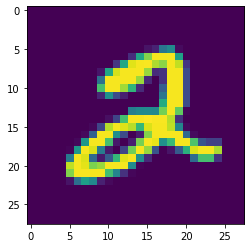

In [26]:
plt.figure()
plt.imshow(data_sample2[0][0].reshape(28, 28))
plt.show()

In [27]:
#define datasets
train_dataset = torch.utils.data.TensorDataset(*data_train)
sample_1_dataset = torch.utils.data.TensorDataset(*data_sample1)
sample_2_dataset = torch.utils.data.TensorDataset(*data_sample2)
valid_dataset = torch.utils.data.TensorDataset(*data_valid)
test_dataset = torch.utils.data.TensorDataset(*data_test)

print(train_dataset.__len__(), test_dataset.__len__())

4903 3147


In [28]:
#define data loaders
random_sampler = torch.utils.data.RandomSampler(train_dataset, replacement = True, num_samples = 512)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=512, sampler = random_sampler)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=512, shuffle=True)
sample1_loader = torch.utils.data.DataLoader(sample_1_dataset, batch_size=512, shuffle=True)
sample2_loader = torch.utils.data.DataLoader(sample_2_dataset, batch_size=512, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=512, shuffle=True)

# Train AAE

In [ ]:
data_size = 784
latent_size = 3
epochs = 1000

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encode_dict = { "ff_layers":[data_size, 512, 256, 128, latent_size],
                "conv_flag":False }

decode_dict = { "ff_layers":[latent_size, 128, 256, 512, data_size],
                "conv_flag":False }

prior_dict = None

#Define model
model = AAE_model(data_size, latent_size, encode_dict, decode_dict, prior_dict, var_decode = False, binary_decode = True)

#push to training device
model.to(model.device)

#Define optimiser
AAE_opt = AAE_optimiser(model, pair_flag = True)

#Define VAE cost
AAE_cost = AAE_loss("BCE", gamma = 1, beta = 1)

#setup model trainer
#indices 1 and 3 are digits zero and one
#pair_points = torch.from_numpy(np.vstack((mnist_train[1][0], mnist_train[3][0]))).float().cuda()

my_trainer = AAE_trainer(model, 
                         AAE_opt, 
                         AAE_cost, 
                         train_loader, 
                         valid_loader, 
                         epochs, 
                         pairwise_samples = (sample1_loader, sample2_loader))

#View model
print(model)

#Train model
my_trainer.train_model()

#Plot results
my_trainer.plotter()


train cost: [ 0.3325 -0.0103  0.0205  0.1665], valid cost: [ 0.2081 -0.0027  0.0124]:  36%|███▋      | 364/1000 [31:05<58:17,  5.50s/it]
train cost: [ 0.3325 -0.0103  0.0205  0.1665], valid cost: [ 0.2081 -0.0027  0.0124]:  36%|███▋      | 365/1000 [31:05<58:10,  5.50s/it]
train cost: [ 0.3373 -0.0098  0.0187  0.1656], valid cost: [ 0.2047 -0.003   0.0116]:  36%|███▋      | 365/1000 [31:11<58:10,  5.50s/it]
train cost: [ 0.3373 -0.0098  0.0187  0.1656], valid cost: [ 0.2047 -0.003   0.0116]:  37%|███▋      | 366/1000 [31:11<58:22,  5.52s/it]
train cost: [ 0.3357 -0.0103  0.0238  0.1656], valid cost: [ 0.2077 -0.0035  0.0158]:  37%|███▋      | 366/1000 [31:16<58:22,  5.52s/it]
train cost: [ 0.3357 -0.0103  0.0238  0.1656], valid cost: [ 0.2077 -0.0035  0.0158]:  37%|███▋      | 367/1000 [31:16<57:30,  5.45s/it]
train cost: [ 0.3314 -0.0114  0.0273  0.1656], valid cost: [ 0.2092 -0.0035  0.0185]:  37%|███▋      | 367/1000 [31:22<57:30,  5.45s/it]
train cost: [ 0.3314 -0.0114  0.0273  0.

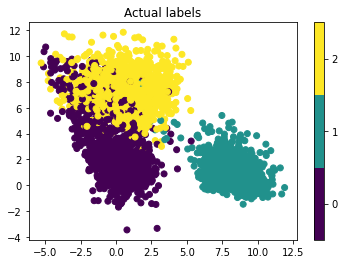

Parameter containing:
tensor([[0., 0., 0.]]) Parameter containing:
tensor([[1., 1., 1.]])


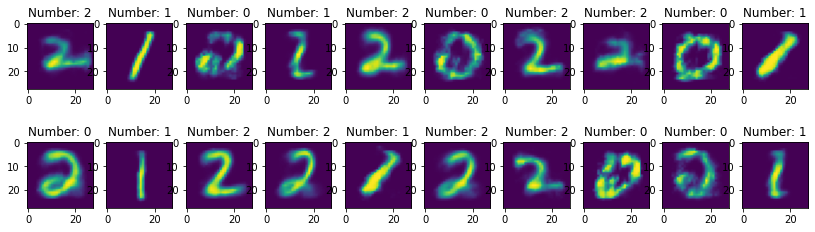

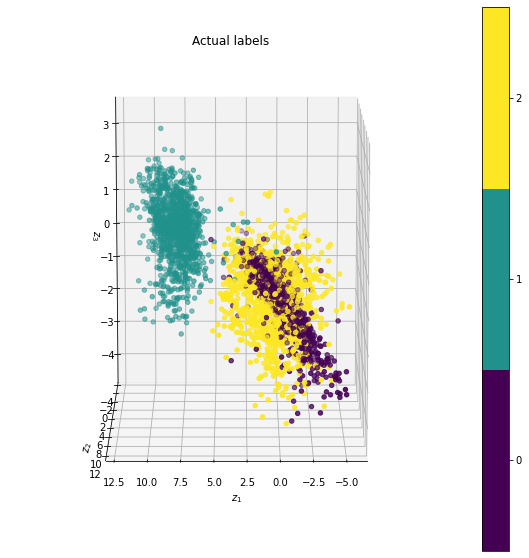

Parameter containing:
tensor([[0., 0., 0.]]) Parameter containing:
tensor([[1., 1., 1.]])


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for cnt, i in enumerate(test_loader):

    d, l = i
    d = d.to(device)
    mu_z, var_z = model.encoder(d)
    recon, _ = model.decoder(mu_z, var_z)

    mu_z = mu_z.detach().cpu().numpy()
    l = l.detach().cpu().numpy()
    recon = recon.detach().cpu().numpy()

    if cnt == 0:
        mu_z_total = mu_z
        l_total = l
        recon_total = recon
    else:
        mu_z_total = np.vstack((mu_z_total, mu_z))
        l_total = np.concatenate((l_total, l))
        recon_total = np.concatenate((recon_total, recon))

fig, ax = plt.subplots(1, 1)

no_classes = 3
cmap = plt.get_cmap('viridis', no_classes)
tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes

ax.set_title("Actual labels")
c = ax.scatter(mu_z_total[:, 0], mu_z_total[:, 1], c = l_total, cmap = cmap)
cb = fig.colorbar(c, ax = ax)
tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes
cb.set_ticks(tick_locs)
# set tick labels (as before)
cb.set_ticklabels(np.arange(no_classes))
plt.show()

mu_z_p, var_z_p = model.prior()
print(mu_z_p, var_z_p)

fig, ax = plt.subplots(2,10, figsize = (14, 4))
ax = ax.flatten()
for i in range(20):
  ax[i].set_title("Number: {}".format(l_total[i]))
  ax[i].imshow(recon_total[i, :].reshape(28, 28))

plt.show()

if latent_size > 2:
    fig = plt.figure(figsize = (10, 10))
    ax = fig.add_subplot(111, projection = '3d')

    no_classes = 3
    cmap = plt.get_cmap('viridis', no_classes)
    tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes

    ax.set_title("Actual labels")
    c = ax.scatter(mu_z_total[:, 0], mu_z_total[:, 1], mu_z_total[:, 2], c = l_total, cmap = cmap)
    cb = fig.colorbar(c, ax = ax)
    tick_locs = (np.arange(no_classes) + 0.5)*(no_classes-1)/no_classes
    cb.set_ticks(tick_locs)
    # set tick labels (as before)
    cb.set_ticklabels(np.arange(no_classes))
    ax.view_init(12, 90)
    ax.set_xlabel(r"$z_1$")
    ax.set_ylabel(r"$z_2$")
    ax.set_zlabel(r"$z_3$")
    plt.show()

    mu_z_p, var_z_p = model.prior()
    print(mu_z_p, var_z_p)

In [40]:
np.save("trial.npy", {"data":mu_z_total,"labels":l_total})

In [ ]:
mu_pp, var_pp = model.encoder(my_trainer.pairwise_samples)
print(mu_pp)

tensor([[-0.0975,  0.0253],
        [-0.0885,  0.0189]], device='cuda:0', grad_fn=<AddmmBackward>)
